# Assignment 2: Building a Modeling Data Set

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

In this assignment, you will complete the following tasks to <b>build a modeling dataset</b>:

1. <b>Load the "adult" data set</b> and identify the <b>number of rows & columns</b>
2. Build a new regression <b>label column</b> by winsorizing outliers
3. Replace all <b>missing values</b> with means
4. <b>Identify</b> two features with the <b>highest correlation with label</b>
5. Build appropriate <b>bivariate plots</b> between the highest correlated features and label

## Part 1. Load the Data

Use the specified file name to load the data. Save it as a Pandas DataFrame called `df`.

**Task**: Read in the data using the `pd.read_csv()` function and save it to DataFrame `df`. Note: use the variable `filename` in your call to `pd.read_csv()`.

In [2]:
# Do not remove or edit the line below:
filename = os.path.join(os.getcwd(), "data", "adult.data.full.asst")

In [3]:
# YOUR CODE HERE
df = pd.read_csv(filename, header=0)

**Task**: Display the shape of `df` -- that is, the number of rows and columns.

In [4]:
# YOUR CODE HERE
df.shape

(32561, 15)

*Check your work*: while we used a small subset of the `adult` dataset in the exercises, the dataset that we are using now has a substantially greater number of rows, but the same number of columns as before. You should see this reflected when you print out the dimensions of DataFrame `df`.

**Task**: Get a peek of the data by displaying the first few rows, as you usually do.

In [5]:
# YOUR CODE HERE
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex_selfID,capital-gain,capital-loss,hours-per-week,native-country,income_binary
0,39.0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Non-Female,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Non-Female,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Non-Female,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Non-Female,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


## Part 2. Create a (Winsorized) Label Column

Assume that your goal is to use this dataset to fit a regression model that predicts the number of years  of education that a person has had.

We'd like to create a new version of the `education-num` column, in which we replace the outlier values of `education-num` (on both sides of the range -- the low end as well as the high end). We will replace the outliers with the corresponding percentile value, as we did in the exercises. That is, if we wish to replace any value below, say, the 1.234-th percentile, we shall replace all such (various) values by the exact same value in our data -- the value such that 1.234% of data lies below it.

We will need to import the `stats` module from the `scipy` package:

In [6]:
import scipy.stats as stats

**Task**: Create a new column, titled `label`, by winsorizing the `education-num` column with the top and bottom 1% percentile values.

In [7]:
# YOUR CODE HERE
df['label'] = stats.mstats.winsorize(df['education-num'],limits=[0.01,0.01])

Let's verify that a new column got added to the DataFrame:

In [8]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex_selfID,capital-gain,capital-loss,hours-per-week,native-country,income_binary,label
0,39.0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Non-Female,2174,0,40.0,United-States,<=50K,13
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Non-Female,0,0,13.0,United-States,<=50K,13
2,38.0,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Non-Female,0,0,40.0,United-States,<=50K,9
3,53.0,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Non-Female,0,0,40.0,United-States,<=50K,7
4,28.0,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K,13


An interesting thing to think about: take a look at the data and notice that for the first five rows, the values of the `education-num` column and its winsorized version -- `label` -- are the same. Does this mean that winsorization did not work? Or are there discrepancies further down the list of rows, where we cannot see them?

**Task**: Check that the values of `education-num` and `label` are *not* identical. You may do this by subtracting the two columns and then listing the unique values of the result. If you see values other than zero, it means *some* change did happen, as we would expect.

In [9]:
# YOUR CODE HERE
holder = np.subtract(df['education-num'],df['label'])
holder.unique()

array([ 0, -1, -2])

## Part 3. Replace the Missing Values With Means

### a. Identifying missingness

**Task**: Check if a given value in any data cell is missing, and sum up the resulting values (`True`/`False`) by columns. Assign the results to variable `nan_count`. Print the results.

In [10]:
# YOUR CODE HERE
nan_count = np.sum(df.isnull(), axis = 0)
nan_count

age                162
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex_selfID           0
capital-gain         0
capital-loss         0
hours-per-week     325
native-country     583
income_binary        0
label                0
dtype: int64

Replacing the missing values with the mean only makes sense for the numerically valued columns (and not for strings). Hence, we will focus on the `age` and `hours-per-week` columns.

### b. Keeping record of the missingness: creating dummy variables 

As a first step, you will now create dummy variables indicating missingness of the values.

**Task**: Store the `True`/`False` series that indicate missingness of any value in `age` as a new column called `age_na`. Store the `True`/`False` series that indicate missingness of every value of `hours-per-week` as a new column called `hours-per-week_na`.

In [11]:
# YOUR CODE HERE
df['age_na'] = df['age'].isnull()
df['hours-per-week_na'] = df['hours-per-week'].isnull()

### c. Replacing the missing values with mean values of the column

**Task**: Fill the missing values of the `age` and `hours-per-week` columns with the mean value of the corresponding column.

In [12]:
# YOUR CODE HERE
mean_ages = df['age'].mean()
mean_weekly = df['hours-per-week'].mean()

df['age'].fillna(value=mean_ages, inplace=True)
df['hours-per-week'].fillna(value=mean_weekly, inplace=True)

<b>Ungraded Task</b>: Check your results. Display the sum of missing values for the `age` column (or reuse the code for listing total numbers of all missing values that you wrote before, if it worked.

In [13]:
# YOUR CODE HERE - this cell will not be graded
np.sum(df['age'].isnull(), axis=0)

0

## Part 4. Identify Features With the Highest Correlation With the Label

Your next goal is to figure out which features in the data correlate most with the label.<br>

In the next few cells, we will demonstrate how to use Pandas `corr()` method to get a list of correlation coefficients between the `label` and all other (numerical) features.  To learn more about the `corr()` method, consult the online [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

Let's first galnce at what the `corr()` method does:

In [14]:
df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,age_na,hours-per-week_na
age,1.000000e+00,-0.076085,0.036685,0.124705,0.057478,6.657191e-02,0.038549,7.101579e-18,-4.325250e-05
fnlwgt,-7.608468e-02,1.000000,-0.043195,-0.002234,-0.010252,-1.804716e-02,-0.042134,-9.015193e-03,-5.769619e-03
education-num,3.668517e-02,-0.043195,1.000000,0.167089,0.079923,1.465533e-01,0.999182,-1.708530e-03,-5.670679e-03
capital-gain,1.247046e-01,-0.002234,0.167089,1.000000,-0.055138,1.009947e-01,0.168202,-5.313515e-03,4.981172e-03
capital-loss,5.747841e-02,-0.010252,0.079923,-0.055138,1.000000,5.420158e-02,0.080453,-7.205893e-03,-1.511760e-03
hours-per-week,6.657191e-02,-0.018047,0.146553,0.100995,0.054202,1.000000e+00,0.147275,2.254277e-03,7.385613e-17
label,3.854869e-02,-0.042134,0.999182,0.168202,0.080453,1.472753e-01,1.000000,-1.955584e-03,-5.811006e-03
age_na,7.101579e-18,-0.009015,-0.001709,-0.005314,-0.007206,2.254277e-03,-0.001956,1.000000e+00,-2.709086e-03
hours-per-week_na,-4.325250e-05,-0.005770,-0.005671,0.004981,-0.001512,7.385613e-17,-0.005811,-2.709086e-03,1.000000e+00


The result is a computed *correlation matrix*. The values on the diagonal are all equal to 1, and the matrix is symmetrical with respect to the diagonal.<br>

We only need to observe correlations of all features with the column `label` (as opposed to every possible pairwise correlation). Se let's query the `label` column of this matrix:

In [15]:
df.corr()['label']

age                  0.038549
fnlwgt              -0.042134
education-num        0.999182
capital-gain         0.168202
capital-loss         0.080453
hours-per-week       0.147275
label                1.000000
age_na              -0.001956
hours-per-week_na   -0.005811
Name: label, dtype: float64

This is good, but contains two values too many: we do not need to observe the correlation of `label` with itself, and moreover we are not interested in the correlation between the label and `education-num` (recall that `label` is a winsorized version of the `education-num`). So we will exclude these two values using the Pandas `drop()` method:

In [16]:
exclude = ['label','education-num']
df.corr()['label'].drop(exclude, axis = 0)

age                  0.038549
fnlwgt              -0.042134
capital-gain         0.168202
capital-loss         0.080453
hours-per-week       0.147275
age_na              -0.001956
hours-per-week_na   -0.005811
Name: label, dtype: float64

**Task**: The code below performs the same operation above, but saves the result to variable `corrs`. Sort the values in `corrs` in descending order. Use the Pandas method `sort_values()`  to accomplish this task. For more information on how to use the `sort_values()` method, consult the online [documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html).

In [17]:
# Do not remove or edit the line below:
corrs = df.corr()['label'].drop(exclude, axis = 0)

corrs_sorted = corrs.sort_values(ascending=False)# YOUR CODE HERE 

**Task**: Save the *column names* for the top-2 correlation values into a  Python list called `top_two_corr` <br>
_Tip_: `corrs_sorted` is a Pandas `Series` object, in which column names are the *index*. Once you find the column names, use the Python `list()` method to convert the values into a Python `list`.

In [18]:
corrs_sorted

capital-gain         0.168202
hours-per-week       0.147275
capital-loss         0.080453
age                  0.038549
age_na              -0.001956
hours-per-week_na   -0.005811
fnlwgt              -0.042134
Name: label, dtype: float64

In [19]:
top_two_corr = (corrs_sorted[:2].index)# YOUR CODE HERE 
list(top_two_corr)

['capital-gain', 'hours-per-week']

## Part 5. Produce Bivariate Plots for the Label and Its Top Correlates

We will use the `pairplot()` function in `seaborn` to plot the relationships between the two features we identified and the label.

**Task**: Create a DataFrame named ` df_sub` that contains only these three columns from DataFrame `df`: the label, and the two columns which correlate with it the most. 

*Tip*: You can use the variable `top_two_corrs` in your solution.

In [20]:
parameters = ['capital-gain', 'hours-per-week', 'label']
df_sub = df[parameters] # YOUR CODE HERE

<b>Task</b>: Create a `seaborn` pairplot of the data subset you just created.

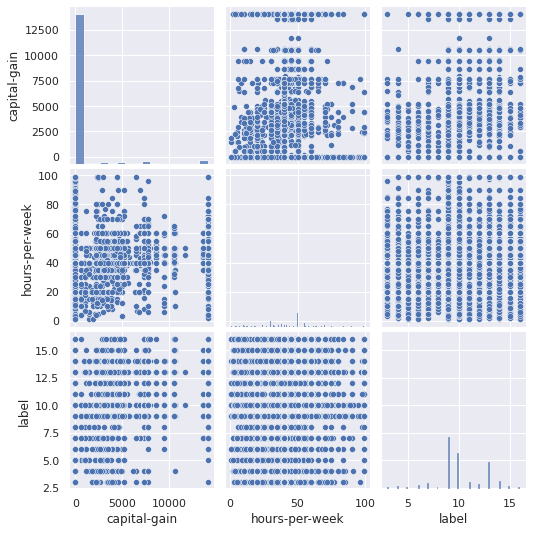

In [21]:
# YOUR CODE HERE
sns.pairplot(df_sub)

This one is not very easy to make sense of: the points overlap, but we do not have visibility into how densely they are stacked together.
<br>

<b>Task</b>: Repeat the `pairplot` exercise, this time specifying the *kernel density estimator* as the *kind* of the plot.<br>
*Tip*: Use `kind = 'kde'` as a parameter of the `pairplot()` function. You could also specify `corner=True` to make sure you don't plot redundant (symmetrical) plots.

Note: This will take a while to run and produce a plot.

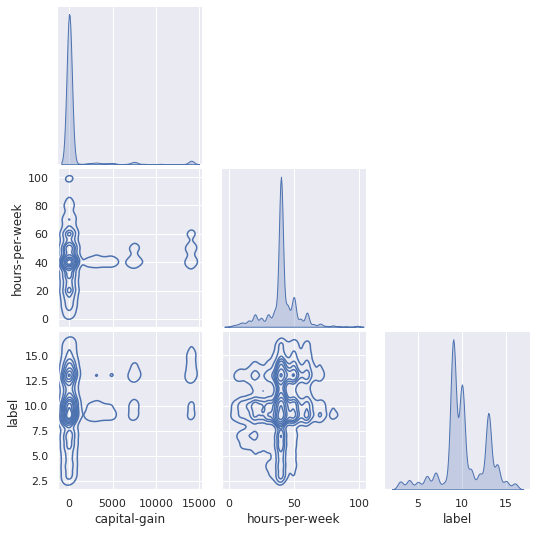

In [22]:
# YOUR CODE HERE
sns.pairplot(df_sub,kind='kde',corner=True)

Think about the possible interpretations of these plots. (Recall that our label encodes `education`, in number of years). <br>
Here is an example of the kind of stories this data seems to be telling. It appears as though hours per week are stacked around the typical 40-hour value, and that this value of weekly hours dominates regardless of the level of education. However, it seems that it is somewhat less typical for people with lower levels of formal education to be working over 65 hours a week. <br>


<b>Analysis</b>: Try to interpret what you see in this plot, as well as the one depicting the relationship between 'capital gain' and the levels of education, and see what kind of patterns you are noticing. Moreover, is there something odd that raises red flags and makes you think the data or our handling of it may be invalid? Is there something that, on the contrary, satisfies your intuition, thereby providing a 'sanity check'? These are the kind of questions that are useful to ask yourself as you are looking at the data distributions and pairwise relationships. Record your findings in the cell below.

The KDE plot at the bottom left demonstrates that individuals with around eight years of education are most likely to have high capital and those with high capital work about 40 - 60 hours per week. Hours per week barely affect capital gain because a cluster of people with low capital work around the same hours. The bottom middle plot shows that around 7.5 years of education and beyond, you start seeing considerable differences between the number of hours worked, with the dominant cluster working about 40 hours per week regardless of education.

We can see, however, that the univariate KDE plot at the top left representing capital gain needs to be balanced, where almost all of the data is shifted to the left, meaning there is a significant quantity of people with low capital. The plot demonstrates there could be some inaccuracies within our model due to the substantial amount of people representing low capital. We could remodel by using winsorization to shift out outliers to balance this or discard the data entirely regardless of correlation. 